# Cardiovascular desease detection

## Project by: PARAS VARSHNEY

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from keras_tqdm import TQDMNotebookCallback
from tqdm import tqdm

import statsmodels
import statsmodels.api as sm

import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import normaltest
from scipy.stats import norm ,rankdata
from scipy.special import boxcox1p
from scipy.optimize import curve_fit

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.externals import joblib 

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import plot_importance

Using TensorFlow backend.


In [2]:
# raw_df = pd.read_csv(data_url, sep=";")
raw_df = pd.read_csv("cardio_train.csv", sep=";")
raw_df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [3]:
print("Data Shape: "+str(raw_df.shape))
print()
print("Columns: "+str(raw_df.columns))
print()
print(raw_df.info())

Data Shape: (69301, 13)

Columns: Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69301 entries, 0 to 69300
Data columns (total 13 columns):
id             69301 non-null int64
age            69301 non-null int64
gender         69301 non-null int64
height         69301 non-null int64
weight         69301 non-null float64
ap_hi          69301 non-null int64
ap_lo          69301 non-null int64
cholesterol    69301 non-null int64
gluc           69301 non-null int64
smoke          69301 non-null int64
alco           69301 non-null int64
active         69301 non-null int64
cardio         69301 non-null int64
dtypes: float64(1), int64(12)
memory usage: 6.9 MB
None


## Data Visualization

In [4]:
def draw_violin_plots(raw_df):
    fig, axes = plt.subplots(1, 3, figsize=(21,6))
    sns.violinplot(x="cardio", y="age", data=raw_df, ax=axes[0])
    sns.violinplot(x="cardio", y="height", data=raw_df, ax=axes[1])
    sns.violinplot(x="cardio", y="weight", data=raw_df, ax=axes[2])

    fig, axes = plt.subplots(1, 3, figsize=(21,6))
    sns.violinplot(x="cardio", y="ap_hi", data=raw_df, ax=axes[0])
    sns.violinplot(x="cardio", y="ap_lo", data=raw_df, ax=axes[1])
    sns.violinplot(x="cardio", y="alco", data=raw_df, ax=axes[2])
    
    fig, axes = plt.subplots(1, 3, figsize=(21,6))
    sns.violinplot(x="cardio", y="cholesterol", data=raw_df, ax=axes[0])
    sns.violinplot(x="cardio", y="gluc", data=raw_df, ax=axes[1])
    sns.violinplot(x="cardio", y="smoke", data=raw_df, ax=axes[2])
    
    fig, axes = plt.subplots(1, 2, figsize=(21,6))
    sns.violinplot(x="cardio", y="active", data=raw_df, ax=axes[0])
    sns.violinplot(x="cardio", y="gender", data=raw_df, ax=axes[1])
    
    
def plot_scatter(data):
    fig, ax = plt.subplots(figsize=(21,6))
    ax.scatter(range(len(data)), data)
    ax.set_xlabel("values")
    ax.set_ylabel("data point")
    plt.show()
    
def plot_scatter_features(raw_df):
    data = raw_df["age"]
    plot_scatter(data)

    data = raw_df["height"]
    plot_scatter(data)

    data = raw_df["weight"]
    plot_scatter(data)

    data = raw_df["ap_hi"]
    plot_scatter(data)

    data = raw_df["ap_lo"]
    plot_scatter(data)
    
# draw_violin_plots(raw_df)


In [5]:
# plot_scatter_features(raw_df)

## Data Cleaning

My plan for data preparation: 
 - drop duplicated rows if any.
 - drop any unusual observation.
 - convert age from days to years.
 - create a column for ranges of age.
 - create a column for body mass index (bmi).
 - create a column for state of bload pressure.
 - convert variable types.

In [6]:
print(raw_df.duplicated().sum())
raw_df.drop_duplicates(inplace=True)

0


In [7]:
raw_df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000
mean,50471.480397,19468.786280,1.349519,164.362217,74.203027,128.829584,96.650092,1.366806,1.226447,0.088051,0.053881,0.803986,0.499589
std,28563.100347,2467.261818,0.476821,8.205337,14.383469,154.775805,189.096240,0.680270,0.572246,0.283371,0.225784,0.396982,0.500003
min,988.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25745.000000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50494.000000,19704.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,75150.000000,21326.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
def feature_outlier_removal(df, feature, min_q, max_q):
    feature_min_outlier_mask = df[feature] > df[feature].quantile(min_q)
    feature_max_outlier_mask = df[feature] < df[feature].quantile(max_q)
    df = df[(feature_min_outlier_mask) & (feature_max_outlier_mask)]
    print(feature, "min: ", df[feature].quantile(min_q))
    print(feature, "max: ", df[feature].quantile(max_q))
    return df

raw_df = feature_outlier_removal(raw_df, "height", 0.005, 0.999)
raw_df = feature_outlier_removal(raw_df, "weight", 0.001, 0.999)

height min:  147.0
height max:  188.0
weight min:  42.0
weight max:  135.0


#### convert age from days to years

In [9]:
raw_df['age'] = round(raw_df['age']/365.25).apply(lambda x: int(x))

#### convert 'gender' to binary

In [10]:
raw_df['gender']= raw_df['gender'].apply(lambda x: 0 if x==2 else 1)

#### 'ap_hi' should be higher than 'ap_lo'

In [11]:
raw_df = raw_df[raw_df['ap_hi'] > raw_df['ap_lo']].reset_index(drop=True)

#### create 'bmi' column from height and weight

In [12]:
def find_bmi(data):
    bmi = data['weight']/((data['height']/100)**2)
    return bmi
    
raw_df['bmi'] = raw_df.apply(find_bmi, axis=1)

<hr>

#### create 'bp_level' column

In [13]:
def bp_level(data):
    if (data['ap_hi'] <= 120) and (data['ap_lo'] <= 80):
        return 'normal'
    if (data['ap_hi'] >= 120 and data['ap_hi'] < 129) and (data['ap_lo'] < 80):
        return 'above_normal'
    if (data['ap_hi'] >= 129 and data['ap_hi'] < 139) | (data['ap_lo'] >= 80 and data['ap_lo'] < 89):
        return 'high'
    if (data['ap_hi'] >= 139) | (data['ap_lo'] >= 89):
        return 'very_high'
    if (data['ap_hi'] >= 180) | (data['ap_lo'] >= 120):
        return 'extreme_high'

    
raw_df['bp_level'] = raw_df.apply(bp_level, axis=1)
raw_df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp_level
0,988,62,1,155,69.0,130,80,2,2,0,0,1,0,28.720083,high
1,989,40,1,163,71.0,110,70,1,1,0,0,1,1,26.722873,normal
2,990,60,1,165,70.0,120,80,1,1,0,0,1,0,25.711662,normal
3,991,40,0,165,85.0,120,80,1,1,1,1,1,0,31.221304,normal
4,992,64,1,155,62.0,120,80,1,1,0,0,1,0,25.806452,normal


#### create 'age_level' column

In [14]:
def age_level(data):
    if data["age"] < 30:
        return '0'
    if data['age'] >= 30 and data['age'] < 40:
        return '1'
    if data['age'] >= 40 and data['age'] < 45:
        return '2'
    if data['age'] >= 45 and data['age'] < 50:
        return '3'
    if data['age'] >= 50 and data['age'] < 55:
        return '4'
    if data['age'] >= 55 and data['age'] < 60:
        return '5'
    if data['age'] >= 60 and data['age'] < 70:
        return '6'
    else:
        return '7'
    
    
raw_df['age_level'] = raw_df.apply(age_level, axis=1)
raw_df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp_level,age_level
0,988,62,1,155,69.0,130,80,2,2,0,0,1,0,28.720083,high,6
1,989,40,1,163,71.0,110,70,1,1,0,0,1,1,26.722873,normal,2
2,990,60,1,165,70.0,120,80,1,1,0,0,1,0,25.711662,normal,6
3,991,40,0,165,85.0,120,80,1,1,1,1,1,0,31.221304,normal,2
4,992,64,1,155,62.0,120,80,1,1,0,0,1,0,25.806452,normal,6


In [15]:
raw_df['age_level'].value_counts()

4    18645
5    15482
6    15112
2     9270
3     8511
1      460
Name: age_level, dtype: int64

#### create 'bmi_level' column

In [16]:
def bmi_level(data):
    if data['bmi'] <= 18.5:
        return 'underweight'
    if data['bmi'] > 18.5 and data['bmi'] <= 24.9:
        return 'normal'
    if data['bmi'] > 24.9 and data['bmi'] <= 29.9:
        return 'overweight'
    if data['bmi'] >= 29.9:
        return 'obese'
    
raw_df['bmi_level'] = raw_df.apply(bmi_level, axis=1)
raw_df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp_level,age_level,bmi_level
0,988,62,1,155,69.0,130,80,2,2,0,0,1,0,28.720083,high,6,overweight
1,989,40,1,163,71.0,110,70,1,1,0,0,1,1,26.722873,normal,2,overweight
2,990,60,1,165,70.0,120,80,1,1,0,0,1,0,25.711662,normal,6,overweight
3,991,40,0,165,85.0,120,80,1,1,1,1,1,0,31.221304,normal,2,obese
4,992,64,1,155,62.0,120,80,1,1,0,0,1,0,25.806452,normal,6,overweight


#### change type of categorical features

In [17]:
# def change_to_category(df):
#     df['gender'] = df['gender'].astype('category')
#     df['cholesterol'] = df['cholesterol'].astype('category')
#     df['gluc'] = df['gluc'].astype('category')
#     df['smoke'] = df['smoke'].astype('category')
#     df['alco'] = df['alco'].astype('category')
#     df['active'] = df['active'].astype('category')
#     df['cardio'] = df['cardio'].astype('category')
#     return df
    

# raw_df = change_to_category(raw_df)

## Hypothesis testing

In [18]:
def hypothesis_testing(feature, target):
    g = pd.crosstab(feature, target, margins=True)

    chi2_result = chi2_contingency(g)
#     print("chi2: ", chi2)
#     print("p-val: ", p)
#     print("degree of freedom: ",dof)
    return chi2_result[1]

In [19]:
df_cols = raw_df.columns
hypothests_result = {}
drop_list = []

for i in tqdm(range(len(df_cols)), position=0, leave=True):
    p = hypothesis_testing(raw_df[df_cols[i]], raw_df['cardio'])
    
    if p < 0.05:
        status = 'reject'
        feature = True
    else:
        status = 'accept'
        feature = False
        drop_list.append(df_cols[i])
    
    hypothests_result[df_cols[i]] = [p, status, feature]

print(hypothests_result, end="\n\n")
print(drop_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 11.93it/s]


{'id': [1.0, 'accept', False], 'age': [0.0, 'reject', True], 'gender': [0.436745838206817, 'accept', False], 'height': [0.8326127530775933, 'accept', False], 'weight': [1.197917813375358e-279, 'reject', True], 'ap_hi': [0.0, 'reject', True], 'ap_lo': [0.0, 'reject', True], 'cholesterol': [0.0, 'reject', True], 'gluc': [1.737803120583091e-117, 'reject', True], 'smoke': [0.0016247932437701547, 'reject', True], 'alco': [0.36712722842226553, 'accept', False], 'active': [2.975411441120063e-20, 'reject', True], 'cardio': [0.0, 'reject', True], 'bmi': [1.0, 'accept', False], 'bp_level': [0.0, 'reject', True], 'age_level': [0.0, 'reject', True], 'bmi_level': [0.0, 'reject', True]}

['id', 'gender', 'height', 'alco', 'bmi']


In [20]:
null_hypothesis_result = pd.DataFrame(hypothests_result, index=['p-value', 'null_hypothesis', 'feature']).T
null_hypothesis_result

,p-value,null_hypothesis,feature
id,1,accept,False
age,0,reject,True
gender,0.436746,accept,False
height,0.832613,accept,False
weight,1.19792e-279,reject,True
ap_hi,0,reject,True
ap_lo,0,reject,True
cholesterol,0,reject,True
gluc,1.7378e-117,reject,True
smoke,0.00162479,reject,True


In [21]:
raw_df.drop(drop_list, axis=1, inplace=True)

In [22]:
print( raw_df.shape)
print(raw_df.isna().sum())
print(raw_df.info())

(67480, 12)
age            0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
active         0
cardio         0
bp_level       0
age_level      0
bmi_level      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67480 entries, 0 to 67479
Data columns (total 12 columns):
age            67480 non-null int64
weight         67480 non-null float64
ap_hi          67480 non-null int64
ap_lo          67480 non-null int64
cholesterol    67480 non-null int64
gluc           67480 non-null int64
smoke          67480 non-null int64
active         67480 non-null int64
cardio         67480 non-null int64
bp_level       67480 non-null object
age_level      67480 non-null object
bmi_level      67480 non-null object
dtypes: float64(1), int64(8), object(3)
memory usage: 6.2+ MB
None


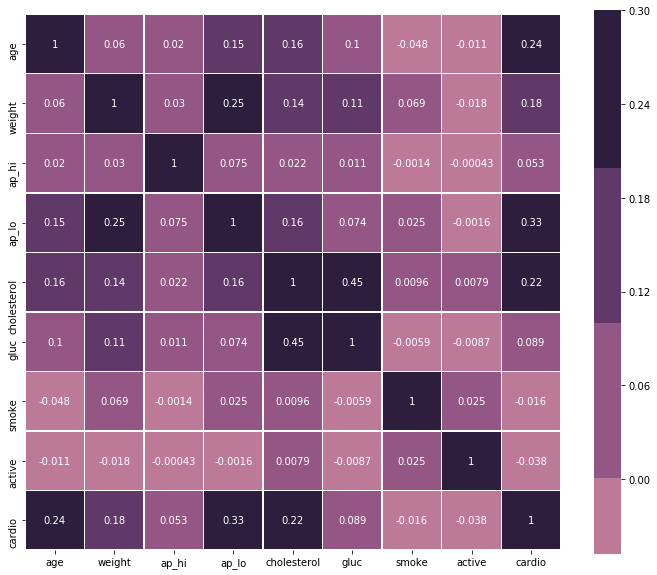

In [23]:
raw_df.corr()
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(raw_df.corr(), annot=True, linewidths=0.5, square=True, vmax=0.3, center=0, cmap=sns.cubehelix_palette())
# plt.savefig('heat.png')

## Working with clean data

In [24]:
clean_data = raw_df.copy()
clean_data.head()

,age,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,active,cardio,bp_level,age_level,bmi_level
0,62,69.0,130,80,2,2,0,1,0,high,6,overweight
1,40,71.0,110,70,1,1,0,1,1,normal,2,overweight
2,60,70.0,120,80,1,1,0,1,0,normal,6,overweight
3,40,85.0,120,80,1,1,1,1,0,normal,2,obese
4,64,62.0,120,80,1,1,0,1,0,normal,6,overweight


In [25]:
clean_data = pd.get_dummies(clean_data,drop_first=False)
clean_data.head()

,age,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,active,cardio,bp_level_above_normal,...,age_level_1,age_level_2,age_level_3,age_level_4,age_level_5,age_level_6,bmi_level_normal,bmi_level_obese,bmi_level_overweight,bmi_level_underweight
0,62,69.0,130,80,2,2,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
1,40,71.0,110,70,1,1,0,1,1,0,...,0,1,0,0,0,0,0,0,1,0
2,60,70.0,120,80,1,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,40,85.0,120,80,1,1,1,1,0,0,...,0,1,0,0,0,0,0,1,0,0
4,64,62.0,120,80,1,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [26]:
def count_categorical_col_values(data, cols):
    for i in cols:
        try:
            print("Categories: ", sorted(data[i].unique()))
            print(data[i].value_counts(), end="\n\n")
        except:
            pass
        
category_cols = ["gender", 'cholesterol', 'gluc', 'alco', 'smoke', 'active', 'bp_level', 'age_level', 'bmi_level']
count_categorical_col_values(clean_data, category_cols)

Categories:  [1, 2, 3]
1    50613
2     9134
3     7733
Name: cholesterol, dtype: int64

Categories:  [1, 2, 3]
1    57384
3     5125
2     4971
Name: gluc, dtype: int64

Categories:  [0, 1]
0    61544
1     5936
Name: smoke, dtype: int64

Categories:  [0, 1]
1    54236
0    13244
Name: active, dtype: int64



In [27]:
clean_data.to_csv('clean_df.csv', index = False)
clean_data.head()

,age,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,active,cardio,bp_level_above_normal,...,age_level_1,age_level_2,age_level_3,age_level_4,age_level_5,age_level_6,bmi_level_normal,bmi_level_obese,bmi_level_overweight,bmi_level_underweight
0,62,69.0,130,80,2,2,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
1,40,71.0,110,70,1,1,0,1,1,0,...,0,1,0,0,0,0,0,0,1,0
2,60,70.0,120,80,1,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,40,85.0,120,80,1,1,1,1,0,0,...,0,1,0,0,0,0,0,1,0,0
4,64,62.0,120,80,1,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


## Data Normalization

In [28]:
clean_df = pd.read_csv("clean_df.csv")
clean_df.head()

,age,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,active,cardio,bp_level_above_normal,...,age_level_1,age_level_2,age_level_3,age_level_4,age_level_5,age_level_6,bmi_level_normal,bmi_level_obese,bmi_level_overweight,bmi_level_underweight
0,62,69.0,130,80,2,2,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
1,40,71.0,110,70,1,1,0,1,1,0,...,0,1,0,0,0,0,0,0,1,0
2,60,70.0,120,80,1,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,40,85.0,120,80,1,1,1,1,0,0,...,0,1,0,0,0,0,0,1,0,0
4,64,62.0,120,80,1,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [29]:
df_X = clean_df.drop(["cardio"], axis=1)
df_y = clean_df.loc[:, "cardio"]

In [30]:
scaler = MinMaxScaler()
df_X = scaler.fit_transform(df_X)
print(df_X)

[[0.91428571 0.27184466 0.00737131 ... 0.         1.         0.        ]
 [0.28571429 0.29126214 0.00612194 ... 0.         1.         0.        ]
 [0.85714286 0.2815534  0.00674663 ... 0.         1.         0.        ]
 ...
 [0.62857143 0.62135922 0.01049475 ... 1.         0.         0.        ]
 [0.88571429 0.30097087 0.00768366 ... 0.         1.         0.        ]
 [0.74285714 0.30097087 0.00674663 ... 0.         1.         0.        ]]


In [31]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

## Model Building

In [32]:
def model_evaluation(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    print("Confusion Matrix:")
    print(cm, end="\n\n")

    TN = cm[0, 0]
    FN = cm[0, 1]
    FP = cm[1, 0]
    TP = cm[1, 1]

    P = FN+TP
    N = TN+FP

    TPR = TP/P
    TNR = TN/N
    FPR = FP/N
    FNR = FN/P

    accuracy = (TN+TP)/(P+N)
    print("Test Accuracy: "+str(accuracy), end="\n\n")
    print("All 4 parameters: ",TN, FN, FP, TP, end="\n\n")
    print("TPR: {}".format(TPR))
    print("TNR: {}".format(TNR))
    print("FPR: {}".format(FPR))
    print("FNR: {}".format(FNR))
    print()
    
    print(classification_report(y_test, y_pred))

In [33]:
# kernel stop here..

### Machine Learning Models

In [34]:
# models = []
# models.append(("LR",LogisticRegression()))
# models.append(("NB",GaussianNB()))
# models.append(("RF",RandomForestClassifier()))
# models.append(("Dtree",DecisionTreeClassifier()))
# models.append(("XGB",xgb.XGBClassifier()))
# models.append(("KNN",KNeighborsClassifier()))
# # models.append(("SVC",SVC()))

# for name,model in models:
#     kfold = KFold(n_splits=2, random_state=22)
#     cv_result = cross_val_score(model,X_train,y_train, cv = kfold, scoring = "accuracy")
#     print(name, cv_result)

### Neural Network

In [35]:
# inp = len(clean_data.columns)
# classifier = Sequential()
# classifier.add(Dense(units = inp, kernel_initializer = 'uniform', activation = 'relu', input_dim = df_X.shape[1]))
# classifier.add(Dropout(0.1))
# classifier.add(Dense(units = inp*2, kernel_initializer = 'uniform', activation = 'relu'))
# classifier.add(Dropout(0.1))
# classifier.add(Dense(units = inp*3, kernel_initializer = 'uniform', activation = 'relu'))
# classifier.add(Dropout(0.1))
# classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
# classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# classifier.fit(df_X, df_y, batch_size = 90, epochs = 3, verbose=0, callbacks=[TQDMNotebookCallback()])

In [36]:
# y_pred = classifier.predict(X_test)
# print(y_pred)
# for i in range(len(y_pred)):
#     if y_pred[i] >= 0.5:
#         y_pred[i] = 1
#     else:
#         y_pred[i] = 0

# model_evaluation(y_test, y_pred)

### XGBoost Classifier

In [37]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
print("Training Accuracy: "+str(xgb_model.score(X_train, y_train)), end="\n\n")
xgb_pred = xgb_model.predict(X_test)
model_evaluation(y_test, xgb_pred)

Training Accuracy: 0.7355327504445762

Confusion Matrix:
[[5356 1496]
 [2006 4638]]

Test Accuracy: 0.740515708358032

All 4 parameters:  5356 1496 2006 4638

TPR: 0.7561134659276165
TNR: 0.7275196957348546
FPR: 0.27248030426514536
FNR: 0.24388653407238345

              precision    recall  f1-score   support

           0       0.73      0.78      0.75      6852
           1       0.76      0.70      0.73      6644

   micro avg       0.74      0.74      0.74     13496
   macro avg       0.74      0.74      0.74     13496
weighted avg       0.74      0.74      0.74     13496



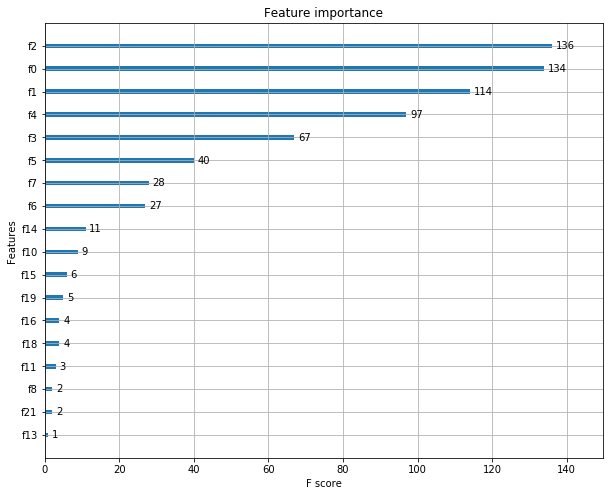

In [38]:
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

#### Hyperparameter tuning for XGBoost Classifier

In [42]:
from sklearn.model_selection import GridSearchCV
param_test = {
 'max_depth':range(1,12,2),
 'min_child_weight':range(1,10,2)
#  'booster':['gbtree', 'gblinear', 'dart']
}
gsearch = GridSearchCV(estimator = xgb.XGBClassifier(nthread=-1), 
                        param_grid = param_test, 
                        scoring='accuracy',
                        n_jobs=-1,
                        iid=False, 
                        cv=10)

gsearch.fit(X_train,y_train)
print(gsearch.best_params_, gsearch.best_score_)

tuned_pred = gsearch.predict(X_test)
model_evaluation(y_test, tuned_pred)

KeyboardInterrupt: 

### RandomForest Classifier

In [40]:
classifier = RandomForestClassifier(n_estimators=32, max_depth=12, oob_score=True, criterion='entropy')
classifier.fit(X_train, y_train)
pr = classifier.predict(X_test)

model_evaluation(y_test, pr)

Confusion Matrix:
[[5290 1562]
 [1996 4648]]

Test Accuracy: 0.7363663307646711

All 4 parameters:  5290 1562 1996 4648

TPR: 0.7484702093397746
TNR: 0.7260499588251441
FPR: 0.2739500411748559
FNR: 0.25152979066022546

              precision    recall  f1-score   support

           0       0.73      0.77      0.75      6852
           1       0.75      0.70      0.72      6644

   micro avg       0.74      0.74      0.74     13496
   macro avg       0.74      0.74      0.74     13496
weighted avg       0.74      0.74      0.74     13496



#### Hyperparameter tuning for RandomForest Classifier

In [41]:
# param_grid = {'n_estimators': [2, 4, 8, 12, 16, 32, 64], 'max_depth': [2, 4, 6, 8, 12]}
# grid_clf = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1, cv=10)
# grid_clf.fit(X_train, y_train)
# print(grid_clf.best_params_, grid_clf.best_score_)

# tuned_pred = grid_clf.predict(X_test)
# model_evaluation(y_test, tuned_pred)